# Case study: Shoebox modeling
In this example, the zone conditions of a small shoebox modeling of a college are going to be studied. The college consists of 4 stories:
- The first story is an office;
- The second story is a laboratory, consisting of the dry lab and wet lab in general;
- The third story is the classrooms;
- The fourth story is a quick-service restaurant (coffee, pastries, and some read-to-use meals).

Each zona has specific fenestration as below:
- The first zone has northern and southern windows with a ratio of 20% of each face. The windows in this zone are two-fold horizontally divided. The Height of the windows in this zone is 1.55 m and the height of the windows from the bottom of the zone is 2.26 m;
- The second zone is a sided window, meaning that each side has fenestration. The total ratio of fenestration for each north, southern, western, and eastern side is 30%. Each side has four-fold windows with the height of 2.15 m and the distance from the bottom of the zone of 1 m;
- The third and the fourth zones are all fenestrated stories, with a ratio of 30%. The windows for each side of these zones are two-fold, with a height of 2.15 m and a 1 m distance for the bottom. 

Each zone for simplicity is considered as a unit with no walls inside by the area of 4 m * 4 m and the height of 4 m. To consider a first-hand understanding of the HVAC consumption for realistic construction from scratch, the first ideal air will be taken as the HVAC system to evaluate the loads of each zone. In this example, the HVAC system is the Ideal load, for each zone. It means that each story has a separate HVAC system that is ideal load. The HVAC system has an air-side economizer with a Differential Dry Bulb type. The HVAC zones are automatically sized. 

It is assumed that the building is in the mixed climate zone according to the ASHRAE standards, and the construction of the building is between 1980-2004. The material type of the building's envelope is considered the default mass (bricks, plaster, concrete, and slabs for the foundation). The schedule operation is assumed to be the default ASHRAE mode of the college as below:

% Schedule operation

Genova is chosen as the location of the building with the specific climatic conditions in https://climate.onebuilding.org/WMO_Region_6_Europe/ITA_Italy/LG_Liguria/ITA_LG_Genoa.161210_TMYx.zip 
The terrain of the building is chosen as a city, where the wind speed is constrained to the city's situation. The full interior and exterior solar beam radiation with reflection is chosen for the study. This means that the interaction of sun radiation towards the windows and the building's envelope with the reflection is fully considered. The method to calculate the beam reflection is polygon clipping, which provides periodic updates of the solar radiation and the shadow.

EnergyPlus has the feature of timestep-wise simulation. You can choose specific time-step per each hour or make the simulation annually, monthly, daily, timestep, or hourly. In this example, the timestep mod is considered for the simulation. EnergyPlus has a specific runtime language, where all the details of a building, should be written in that style with the format of IDF. The IDF file of this simulation is attached to this workspace. 

The below information of a full-year timestep-wise simulation will be gathered on a daily and monthly average:

### Site conditions:
1. Site Outdoor Air Drybulb Temperature [C]
2. Site Outdoor Air Dewpoint Temperature [C]
3. Site Outdoor Air Wetbulb Temperature [C]
4. Site Outdoor Air Barometric Pressure [Pa]
5. Site Wind Speed [m/s]
6. Site Wind Direction [deg]
7. Site Sky Temperature [C]
8. Site Diffuse Solar Radiation Rate per Area [W/m2]
9. Site Direct Solar Radiation Rate per Area [W/m2]
10. Site Outdoor Air Enthalpy [J/kg]

### Zone conditions: 
1. Zone Operative Temperature [C]
2. Zone Mean Radiant Temperature [C]
3. Zone Ideal Loads Supply Air Total Heating Energy [J] 
4. Zone Ideal Loads Supply Air Total Cooling Energy [J]
5. Zone People Total Heating Energy [J]
6. Zone Infiltration Total Heat Loss Energy [J]
7. Zone Lights Electricity Energy [J]
8. Zone Electric Equipment Electricity Energy [J]
9. Zone Windows Total Transmitted Solar Radiation Energy [J]



# Learning outcome:
- Understanding how to measure and calculate the principal factors involved in the energy consumption of a building using EnergyPlus API tools;
- Evaluating the factors based on daily and monthly classification;
- Performing specific sensitivity analysis on the factors;

This example has exercises in different levels: easy, medium, and advanced. Solving the examples gives students a broad horizon of the core aspects of energy consumption.

# Step 01: Loading libraries
Four levels of libraries need to be loaded: system level to work with the directories and Python fundamental processing system, energy engineering libraries to simulate the energy consumption of a building, libraries to work with dataframes and interactive plotting library.

### Note: all figures are interactive and you can zoom in/out and extract the figure as image files for your reports. 


In [1]:
# System-level libraries
import os
import subprocess

# Simulation libraries
import openstudio
from pyenergyplus.api import EnergyPlusAPI
import esoreader 

# Data analysis libraries
import pandas as pd
from datetime import timedelta, datetime

# Plotting libraries
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"


# Step 01: Setting EnergyPlus Environment

In this step, the Energyplus engine and the API to perform the simulation are managed. 

### Important NOTE: the address of the installed EnergyPlus is crucial and should be chosen carefully. Recommended to install EnergyPlus with the default directory.

The EnergyPlus version 23-2-0 which is a stable distribution is used to do the analysis and can be downloaded from the link below:


https://github.com/NREL/EnergyPlus/releases/tag/v23.2.0

In [2]:
# Set environment variables for EnergyPlus
os.environ['ENERGYPLUS_INSTALL_PATH'] = './EnergyPlus-23-2-0'  # Use relative path in Binder environment
os.environ['PATH'] += os.pathsep + './EnergyPlus-23-2-0/PostProcess'  # Ensure PostProcess folder is in PATH

# Define the output directory for simulation results
output_dir = './Output_Results'
api = EnergyPlusAPI()


# Step 02: Retrieving Information functions 

In this part three important functions are loaded to start the simulation, one is read_timestep_from_idf to retrieve the timestep from the IDF file. The second function is generate_timestamps to create the <code style="color : red">TIMESTAMP</code>. This is important to categorize the data into daily, monthly, and time-based sections. The third function is the EnergyPlus runner. The input arguments are the path of IDF, the path of EPW, and the directory to save the results. The EPW file is the energy plus weather file where the suitable link to download is https://www.ladybug.tools/epwmap/


In [3]:
def read_timestep_from_idf(idf_path):
    """
    Reads the timestep value from an EnergyPlus IDF file.
    """
    with open(idf_path, 'r') as file:
        lines = file.readlines()

    # Loop through the lines to find the "Timestep" object
    for i, line in enumerate(lines):
        if line.strip().startswith("Timestep"):
            timestep_line = lines[i + 1].strip()
            timestep_value = timestep_line.split(';')[0].strip()
            return int(timestep_value)
    return None

def generate_timestamps(timestep, num_records):
    """
    Generates timestamps for simulation results based on the timestep value.
    """
    interval_minutes = 60 // timestep
    timestamps = []
    current_time = datetime(year=2006, month=1, day=1, hour=0, minute=0, second=0)

    for i in range(num_records + timestep):
        timestamps.append(current_time)
        current_time += timedelta(minutes=interval_minutes)
    
    return timestamps[:num_records]

def run_energyplus_simulation(idf_path, epw_path, output_dir):
    """
    Runs an EnergyPlus simulation using the EnergyPlus API.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    state = api.state_manager.new_state()
    api.runtime.set_console_output_status(state, True)
    api.runtime.run_energyplus(state, ['-r', '-d', output_dir, '-w', epw_path, idf_path])
    print("Simulation has successfully finished")
    return output_dir


# Step 03: Setting up required file directories:

In this part, the directory of the EnergyPlus runner function is set. It is recommended to use the raw format of paths. The directories are as follows:
- IDF file
- eps file
- Output Results 

By running the below cell, the EnergyPlus will simulate the case study and save the files into the directory, here named as <code style="color : red">Output_Results</code>

In [4]:
idf_path = './Sample2.idf'  # Use relative path for IDF file
epw_path = './ITA_LG_Genoa.161210_TMYx.epw'  # Use relative path for EPW file
output_dir = './Output_Results'  # Output directory

# Read timestep value from the IDF file
timestep = read_timestep_from_idf(idf_path)
print(f"Timestep read from IDF file: {timestep}")

# Run the EnergyPlus simulation
run_energyplus_simulation(idf_path, epw_path, output_dir)


Timestep read from IDF file: 10
Simulation has successfully finished


'Output_Results'

# Step 04: Schematic representation of the case study

By running the section below, you will see the simplified shoebox schematic of the case study. Note that, most of the EnergyPlus functionalities are written in Ruby. In the cell below, the EnergyPlus IDF file will be transformed into the OpenStudio Model (OSM) using a pythonic wrapper of Ruby SDK. Then, the schematic of the building will be shown in a Plotly figure.

In [5]:
def convert_idf_to_osm_using_ruby(idf_path, osm_output_path):
    """
    Converts an IDF file to an OSM file using a Ruby script.
    """
    ruby_executable = '/usr/bin/ruby'  # Ensure Ruby is installed and available in Binder environment
    ruby_script_path = './convert_idf_to_osm.rb'  # Use relative path for Ruby script
    
    if not os.path.exists(ruby_script_path):
        raise FileNotFoundError(f"Ruby script not found: {ruby_script_path}")

    env = os.environ.copy()
    env['GEM_HOME'] = './openstudio-3.7.0/Ruby'  
    env['GEM_PATH'] = './openstudio-3.7.0/Ruby'  
    env['RUBYLIB'] = './openstudio-3.7.0/Ruby'
    env['PATH'] = f"{env['PATH']}:/usr/bin"  # Update PATH to include Ruby directory
    
    result = subprocess.run([ruby_executable, ruby_script_path, idf_path, osm_output_path], capture_output=True, text=True, env=env)

    print(f"Standard Output:\n{result.stdout}")
    print(f"Standard Error:\n{result.stderr}")

    if result.returncode == 0:
        print(f"Conversion complete. OSM file saved to {osm_output_path}")
    else:
        raise RuntimeError(f"Conversion failed with exit code {result.returncode}")

idf_path = './Sample2.idf'  
osm_output_path = './Output_Results/converted_model.osm'  

# Convert IDF to OSM using Ruby script
convert_idf_to_osm_using_ruby(idf_path, osm_output_path)

# Load the OSM model using OpenStudio
osm_path = openstudio.path('./Output_Results/converted_model.osm')
translator = openstudio.osversion.VersionTranslator()
model = translator.loadModel(osm_path)

if model.is_initialized():
    model = model.get()
    print("Model loaded successfully")
else:
    print("Failed to load model")
    model = None

# Continue with visualization code


Standard Output:
[openstudio.energyplus.ReverseTranslator] <1> WorkspaceObject is not IddObjectType: DesignSpecification:OutdoorAir
[openstudio.energyplus.ReverseTranslator] <1> WorkspaceObject is not IddObjectType: DesignSpecification:OutdoorAir
[openstudio.energyplus.ReverseTranslator] <1> WorkspaceObject is not IddObjectType: DesignSpecification:OutdoorAir
[openstudio.energyplus.ReverseTranslator] <1> WorkspaceObject is not IddObjectType: DesignSpecification:OutdoorAir
Successfully converted IDF to OSM and saved to: Output_Results\converted_model.osm

Standard Error:

Conversion complete. OSM file saved to Output_Results\converted_model.osm
Model loaded successfully


# Step 05: Preparing to read the information results

Here esoreader library will be used to read results from .eso file in the output directory. This is mandatory further to be used to create dataframes of specific outputs.

In [6]:
eso = esoreader.read_from_path(r"Output_Results\eplusout.eso")

# Step 06: Plotting results


## <code style="color : red">Important: the title spell is very important and should be aligned with the E+ I/O and Engineering Reference Docs</code> in the link below 


https://energyplus.net/assets/nrel_custom/pdfs/pdfs_v24.1.0/InputOutputReference.pdf

https://energyplus.net/assets/nrel_custom/pdfs/pdfs_v24.1.0/EngineeringReference.pdf

All the documentation can be found in the installed EnergyPlus directory. 

With these two commands, `find_variable` and `to_frame` the output variable will be found and cast to a dataframe. `Important Note: when working with this example, by changing the EPW file, the information will be changed.`

### <code style="color : aqua">Site Outdoor Air Drybulb Temperature [C]</code>

The site's outdoor air dry bulb temperature will be investigated here. 
In the terminology of EnergyPlus, when there is a `Site` word, it means that the variable is about the characteristics of the environment. The dry bulb temperature is the climatic temperature of the air without considering the moisture. To experimentally, calculate the dry bulb temperature, a thermometer encapsulated in a case, known as a Stevenson screen, with standard height from the ground between 1.5 m to 2 m under the direct solar radiation, is used. In most HVAC load calculations, outdoor air dry-bulb temperature plays a pivotal role. The EnergyPlus engine retrieves the information from the EPW file. Here, the outdoor air dry bulb temperature is calculated on average daily and monthly. From the daily average site outdoor air dry bulb temperature, the hottest day in 2006 in Genova, is the 4th of August by 26.87 [C]. The three top hottest months in Genova are June, July, and August and January is the coldest month with an average temperature of 5.61 [C].

In [7]:
eso.find_variable('Site Outdoor Air Drybulb Temperature')

Site_Outdoor_Air_Drybulb_Temperature = eso.to_frame('Site Outdoor Air Drybulb Temperature')

Site_Outdoor_Air_Drybulb_Temperature = Site_Outdoor_Air_Drybulb_Temperature.rename(
    columns={
        'Environment': 'Site_Outdoor_Air_Drybulb_Temperature'
    }
)

num_records = len(Site_Outdoor_Air_Drybulb_Temperature)
timestamps = generate_timestamps(timestep, num_records)

Site_Outdoor_Air_Drybulb_Temperature['Timestamp'] = timestamps
Site_Outdoor_Air_Drybulb_Temperature = Site_Outdoor_Air_Drybulb_Temperature[['Timestamp'] + [col for col in Site_Outdoor_Air_Drybulb_Temperature if col != 'Timestamp']]
Site_Outdoor_Air_Drybulb_Temperature.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Outdoor_Air_Drybulb_Temperature = Site_Outdoor_Air_Drybulb_Temperature.resample('D').mean()

# Monthly average
monthly_avg_Site_Outdoor_Air_Drybulb_Temperature = Site_Outdoor_Air_Drybulb_Temperature.resample('M').mean()

- Daily average site outdoor air drybulb temperature

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Outdoor_Air_Drybulb_Temperature.index, y=daily_avg_Site_Outdoor_Air_Drybulb_Temperature['Site_Outdoor_Air_Drybulb_Temperature'],
                         mode='lines', name='Site condition'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Outdoor Air Drybulb Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Drybulb Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site outdoor air drybulb temperature

In [9]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Outdoor_Air_Drybulb_Temperature.index, 
    y=monthly_avg_Site_Outdoor_Air_Drybulb_Temperature['Site_Outdoor_Air_Drybulb_Temperature'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

month_labels = monthly_avg_Site_Outdoor_Air_Drybulb_Temperature.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Site Outdoor Air Drybulb Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Drybulb Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Site_Outdoor_Air_Drybulb_Temperature.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Site Outdoor Air Dewpoint Temperature [C]</code>

The air dewpoint temperature is the temperature when the air becomes completely saturated with vapors, leading to water condensation. The dewpoint temperature is used to evaluate the moisture level inside the building, to halt mold growing maintaining the required level of indoor air quality (IAQ) and thermal comfort. To experiment with the dewpoint temperature, a device named a hygrometer is used; where the shield is cooled down to observe the first condensation on the mirror of the device. The temperature where the condensation happens is the dewpoint temperature. According to the figures, January 26th has the lowest dewpoint temperature of -12.17 [C]. January and February are the months where water drop condensation periodically happens more.  EnergyPlus API reports the values of the Site's Outdoor Air Dewpoint Temperature for the EPW file. 

In [10]:
eso.find_variable('Site Outdoor Air Dewpoint Temperature')

Site_Outdoor_Air_Dewpoint_Temperature = eso.to_frame('Site Outdoor Air Dewpoint Temperature')

Site_Outdoor_Air_Dewpoint_Temperature = Site_Outdoor_Air_Dewpoint_Temperature.rename(
    columns={
        'Environment': 'Site_Outdoor_Air_Dewpoint_Temperature'
    }
)

num_records = len(Site_Outdoor_Air_Dewpoint_Temperature)
timestamps = generate_timestamps(timestep, num_records)

Site_Outdoor_Air_Dewpoint_Temperature['Timestamp'] = timestamps
Site_Outdoor_Air_Dewpoint_Temperature = Site_Outdoor_Air_Dewpoint_Temperature[['Timestamp'] + [col for col in Site_Outdoor_Air_Dewpoint_Temperature if col != 'Timestamp']]
Site_Outdoor_Air_Dewpoint_Temperature
Site_Outdoor_Air_Dewpoint_Temperature.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Outdoor_Air_Dewpoint_Temperature = Site_Outdoor_Air_Dewpoint_Temperature.resample('D').mean()

# Monthly averages
monthly_avg_Site_Outdoor_Air_Dewpoint_Temperature = Site_Outdoor_Air_Dewpoint_Temperature.resample('M').mean()

- Daily average site outdoor air dewpoint temperature:

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Outdoor_Air_Dewpoint_Temperature.index, y=daily_avg_Site_Outdoor_Air_Dewpoint_Temperature['Site_Outdoor_Air_Dewpoint_Temperature'],
                         mode='lines', name='Site condition'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Outdoor Air Dewpoint Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Air Dewpoint Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600  
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site outdoor air dewpoint temperature:

In [12]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Outdoor_Air_Dewpoint_Temperature.index, 
    y=monthly_avg_Site_Outdoor_Air_Dewpoint_Temperature['Site_Outdoor_Air_Dewpoint_Temperature'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

month_labels = monthly_avg_Site_Outdoor_Air_Dewpoint_Temperature.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Site Outdoor Air Dewpoint Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Air Dewpoint Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Site_Outdoor_Air_Dewpoint_Temperature.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Site Outdoor Air Wetbulb Temperature [C]</code>

Wet bulb temperature shows the lowest degree where evaporative cooling happens. This index mixes the idea of drybulb (dry temperature) and dewpoint (humidity). This factor is important in designing the HVAC models to evaluate energy consumption by estimating the efficiency of the cooling load systems to avoid the potential of condensation. A psychrometer is used to experimentally measure the wet bulb temperature of the outdoor air. It consists of two bulbs where one is a dry and the other is a wet bulb. The air passes through the chamber and because of the evaporative cooling, the wet bulb temperature is lower than the dry bulb except when the relative humidity is 100% and is saturated. The wet bulb temperature can be estimated using psychrometric charts or alternatively equations between different factors. EnergyPlus calculates the wet bulb temperature iteratively using the relative humidity, dewpoint temperature, and dry bulb temperature. Stull formula is another way, that EnergyPlus uses to evaluate the outdoor air wet-bulb temperature as follows:

$T_w \approx c \cdot \text{atan}(0.151977 \cdot \sqrt{RH + 8.313659}) + \text{atan}(T + RH) - \text{atan}(RH - 1.676331) + 0.00391838 \cdot RH^{3/2} \cdot \text{atan}(0.023101 \cdot RH) - 4.686035$ 

https://simulationresearch.lbl.gov/modelica/releases/v10.0.0/help/Buildings_Utilities_Psychrometrics.html

where:
- $T_w$ is the wet bulb temperature;
- $T$ is the dry bulb temperature;
- $RH$ is the relative humidity in [$\%$].

According to the EnergyPlus results, January has the lowest outdoor air wet bulb temperature and July has the highest.


In [13]:
eso.find_variable('Site Outdoor Air Wetbulb Temperature')

Site_Outdoor_Air_Wetbulb_Temperature = eso.to_frame('Site Outdoor Air Wetbulb Temperature')

Site_Outdoor_Air_Wetbulb_Temperature = Site_Outdoor_Air_Wetbulb_Temperature.rename(
    columns={
        'Environment': 'Site_Outdoor_Air_Wetbulb_Temperature'
    }
)

num_records = len(Site_Outdoor_Air_Wetbulb_Temperature)
timestamps = generate_timestamps(timestep, num_records)

Site_Outdoor_Air_Wetbulb_Temperature['Timestamp'] = timestamps

Site_Outdoor_Air_Wetbulb_Temperature = Site_Outdoor_Air_Wetbulb_Temperature[['Timestamp'] + [col for col in Site_Outdoor_Air_Wetbulb_Temperature if col != 'Timestamp']]
Site_Outdoor_Air_Wetbulb_Temperature

Site_Outdoor_Air_Wetbulb_Temperature.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Outdoor_Air_Wetbulb_Temperature = Site_Outdoor_Air_Wetbulb_Temperature.resample('D').mean()

# Monthly averages
monthly_avg_Site_Outdoor_Air_Wetbulb_Temperature = Site_Outdoor_Air_Wetbulb_Temperature.resample('M').mean()

- Daily average site outdoor air wetbulb temperature:

In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Outdoor_Air_Wetbulb_Temperature.index, y=daily_avg_Site_Outdoor_Air_Wetbulb_Temperature['Site_Outdoor_Air_Wetbulb_Temperature'],
                         mode='lines', name='Site condition'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Outdoor Air Wetbulb Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Air Wetbulb Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site outdoor air wetbulb temperature:

In [15]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Outdoor_Air_Wetbulb_Temperature.index, 
    y=monthly_avg_Site_Outdoor_Air_Wetbulb_Temperature['Site_Outdoor_Air_Wetbulb_Temperature'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

month_labels = monthly_avg_Site_Outdoor_Air_Wetbulb_Temperature.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Site Outdoor Air Wetbulb Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Air Wetbulb Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Site_Outdoor_Air_Wetbulb_Temperature.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Site Outdoor Air Barometric Pressure [Pa]</code>

The outdoor air barometric pressure represents the force executed by the atmosphere on a specific location. The air barometric pressure is used to calculate the air density, which is critical in the airflow rate, heat transfer, performance, and energy consumption of HVAC systems in buildings. Barometers are used to measure the outdoor air barometric pressure. There exist distinct barometer types like mercury column, aneroid cell, and digital. EnergyPlus extracts the information of outdoor air barometric pressure from the EPW files in [Pa]. According to the detailed average daily figure, the outdoor air barometric pressure has seasonality features. September has the lowest barometric pressure, and December has the highest outdoor air barometric pressure in Genova.

In [16]:
eso.find_variable('Site Outdoor Air Barometric Pressure')

Site_Outdoor_Air_Barometric_Pressure = eso.to_frame('Site Outdoor Air Barometric Pressure')

Site_Outdoor_Air_Barometric_Pressure = Site_Outdoor_Air_Barometric_Pressure.rename(
    columns={
        'Environment': 'Site_Outdoor_Air_Barometric_Pressure'
    }
)

num_records = len(Site_Outdoor_Air_Barometric_Pressure)
timestamps = generate_timestamps(timestep, num_records)

Site_Outdoor_Air_Barometric_Pressure['Timestamp'] = timestamps

Site_Outdoor_Air_Barometric_Pressure = Site_Outdoor_Air_Barometric_Pressure[['Timestamp'] + [col for col in Site_Outdoor_Air_Barometric_Pressure if col != 'Timestamp']]
Site_Outdoor_Air_Barometric_Pressure

Site_Outdoor_Air_Barometric_Pressure.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Outdoor_Air_Barometric_Pressure = Site_Outdoor_Air_Barometric_Pressure.resample('D').mean()

# Monthly averages
monthly_avg_Site_Outdoor_Air_Barometric_Pressure = Site_Outdoor_Air_Barometric_Pressure.resample('M').mean()

- Daily average site outdoor air wetbulb temperature:

In [17]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Outdoor_Air_Barometric_Pressure.index, y=daily_avg_Site_Outdoor_Air_Barometric_Pressure['Site_Outdoor_Air_Barometric_Pressure'],
                         mode='lines', name='Site condition'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Outdoor Air Barometric Pressure',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Air Barometric Pressure [Pa]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site outdoor air wetbulb temperature:

In [18]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Outdoor_Air_Barometric_Pressure.index, 
    y=monthly_avg_Site_Outdoor_Air_Barometric_Pressure['Site_Outdoor_Air_Barometric_Pressure'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

month_labels = monthly_avg_Site_Outdoor_Air_Barometric_Pressure.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Site Outdoor Air Barometric Pressure',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Air Barometric Pressure [Pa]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Site_Outdoor_Air_Barometric_Pressure.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Site Wind Speed [m/s]</code>
Wind speed is the velocity of air flowing around the surface. Site wind speed is an important factor in forecasting meteorological conditions and HVAC design. Wind speed affects the surface heat transfer and natural ventilation. Additionally indoor air quality and pollutant dispersion have crucial roles. Anemometers are used to measure the wind speed across the regions. The conventional types of anemometers are the cup ones, where two to four cups are attached horizontally to a T-type rode. As the wind blows, the cups start to spin and the rotation speed is proportional to the wind speed. EnergyPlus uses EPW file to have site wind speed in [m/s]. However, the actual wind speed around a building is different from the one measures from the experimental sites, usually, airports have meteorological measurement zones. The wind speed should be scaled to be in a reasonable range; to do so, EnergyPlus uses power law equations as follows:

$V = V_{ref} \times \left(\frac{H}{H_{ref}}\right)^{\alpha}$

where:
- $V$ is the wind speed at height of $H$;
- $V_ref$ is the reference wind speed from the reference height of measurement $H_ref$;
- $\alpha$ is the wind profile exponent. The values of $\alpha$ reads from the below table: https://energyplus.net/assets/nrel_custom/pdfs/pdfs_v24.1.0/EngineeringReference.pdf


| Terrain Description   |      Exponent factor      |
|----------|:-------------:|
| Flat, open country |  0.14 |
| Rough, wooded country |    0.22   |
| Towns and cities | 0.33 |
| Oceans | 0.10 |
| Urban, industrial, forest | 0.22 |

According to the EnergyPlus analysis, July is the least and December is the most windy month in Genova.

In [19]:
eso.find_variable('Site Wind Speed')

Site_Wind_Speed = eso.to_frame('Site Wind Speed')

Site_Wind_Speed = Site_Wind_Speed.rename(
    columns={
        'Environment': 'Site_Wind_Speed'
    }
)

num_records = len(Site_Wind_Speed)
timestamps = generate_timestamps(timestep, num_records)

Site_Wind_Speed['Timestamp'] = timestamps

Site_Wind_Speed = Site_Wind_Speed[['Timestamp'] + [col for col in Site_Wind_Speed if col != 'Timestamp']]

Site_Wind_Speed.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Wind_Speed = Site_Wind_Speed.resample('D').mean()

# Monthly averages
monthly_avg_Site_Wind_Speed = Site_Wind_Speed.resample('M').mean()

- Daily average site wind speed:

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Wind_Speed.index, y=daily_avg_Site_Wind_Speed['Site_Wind_Speed'],
                         mode='lines', name='Site condition'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Wind Speed',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Wind Speed [m/s]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site wind speed:

In [21]:
import plotly.graph_objects as go
import plotly.io as pio

# Set default template to white background
pio.templates.default = "plotly_white"

# Create the figure
fig = go.Figure()

# Add traces for each story's operative temperature data with custom lines and markers
fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Wind_Speed.index, 
    y=monthly_avg_Site_Wind_Speed['Site_Wind_Speed'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  # Solid line
    marker=dict(symbol='circle', size=8)  # Circle markers
))

# Convert the x-axis labels to month-year format for categorical display
month_labels = monthly_avg_Site_Wind_Speed.index.strftime('%b %Y')

# Set the title and axis labels with Times New Roman font without LaTeX style
fig.update_layout(
    title={
        'text': 'Average Monthly Site Wind Speed',
        'y': 0.90,  # Move title up slightly
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Wind Speed [m/s]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  # Change x-axis type to category
        tickvals=monthly_avg_Site_Wind_Speed.index,
        ticktext=month_labels,
        tickangle=45  # Rotate labels for better readability
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  # Background color outside the plot
    plot_bgcolor='white',   # Background color inside the plot
    margin=dict(l=60, r=60, t=100, b=60),  # Increase top margin
    showlegend=True,
    width=1100,  # Set the width of the figure
    height=600   # Set the height of the figure
)

# Add a box (border) around the plot area
fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

# Show the figure
fig.show()


### <code style="color : aqua">Site Wind Direction [deg]</code>

Site wind direction is the clockwise direction of the wind from the true north. For instance, if the wind direction is 270 $\degree$, it means that the wind blows from the west, 180 $\degree$ is from the south, 90 $\degree$ is from the east, and 0 $\degree$ is from the north. The wind direction interacts with the energy consumption of the building and the loads over the HVAC system. Windward sides of the building are faced with high pressure, rectifying natural ventilation. While leeward faces may experience suction. To experimentally obtain the wind direction, wind vanes are used. EnergyPlus obtains site wind direction from the EPW file. According to the average monthly figure, wind in Genova overall comes from south and west rather than north and east.

In [22]:
eso.find_variable('Site Wind Direction')

Site_Wind_Direction = eso.to_frame('Site Wind Direction')

Site_Wind_Direction = Site_Wind_Direction.rename(
    columns={
        'Environment': 'Site_Wind_Direction'
    }
)

num_records = len(Site_Wind_Direction)
timestamps = generate_timestamps(timestep, num_records)

Site_Wind_Direction['Timestamp'] = timestamps
Site_Wind_Direction = Site_Wind_Direction[['Timestamp'] + [col for col in Site_Wind_Direction if col != 'Timestamp']]
Site_Wind_Direction.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Wind_Direction = Site_Wind_Direction.resample('D').mean()

# Monthly averages
monthly_avg_Site_Wind_Direction = Site_Wind_Direction.resample('M').mean()

- Daily average site wind direction:

In [23]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Wind_Direction.index, y=daily_avg_Site_Wind_Direction['Site_Wind_Direction'],
                         mode='lines', name='Site condition'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Wind Direction',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Wind Direction (deg)',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site wind direction:

In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Wind_Direction.index, 
    y=monthly_avg_Site_Wind_Direction['Site_Wind_Direction'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

month_labels = monthly_avg_Site_Wind_Direction.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Site Sky Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Wind Direction (deg)',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Site_Wind_Direction.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Site Sky Temperature [C]</code>

Site sky temperature is the the temperature of the sky of a specific location. This paramter shows the relation between long-wave radiation between sky and building and is influnetial in evaluating the heat loss from building surfaces. Note that, sky behaves like a cold sink, importantly during night, causing remarkable heat loss by radiation. The measurement of the sky temperature is not easy and straight-forward. However, a pyrgeometer is used to measure the long-wave radiation ejected by the sky. EnergyPlus calculates the sky temperature by the below formula:

$T_{sky} = \left(\frac{IR_{H}}{\sigma}\right)^{0.25}-237.15$

where:
- $T_{sky}$ is the men sky temperature;
- $\left(\frac{IR_{H}}{\sigma}\right)$ is the infrared radiation from the sky in $\frac{W}{m^{2}}$;
- $\sigma$ is the Stefan-Boltzmann constant that is $5.6697 \times 10^{-8}$ [$\frac{W}{m^{2}K^{4}}$].

The EnergyPlus calculation shows that the Genova has the coldest sky in December, January, and February and has the hottest sky in July.

In [25]:
eso.find_variable('Site Sky Temperature')

Site_Sky_Temperature = eso.to_frame('Site Sky Temperature')
Site_Sky_Temperature = Site_Sky_Temperature.rename(
    columns={
        'Environment': 'Site_Sky_Temperature'
    }
)

num_records = len(Site_Sky_Temperature)
timestamps = generate_timestamps(timestep, num_records)

Site_Sky_Temperature['Timestamp'] = timestamps

Site_Sky_Temperature = Site_Sky_Temperature[['Timestamp'] + [col for col in Site_Sky_Temperature if col != 'Timestamp']]
Site_Sky_Temperature.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Sky_Temperature = Site_Sky_Temperature.resample('D').mean()

# Monthly averages
monthly_avg_Site_Sky_Temperature = Site_Sky_Temperature.resample('M').mean()

- Daily average site sky temperature

In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Sky_Temperature.index, y=daily_avg_Site_Sky_Temperature['Site_Sky_Temperature'],
                         mode='lines', name='Site condition'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Sky Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site sky temperature

In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Sky_Temperature.index, 
    y=monthly_avg_Site_Sky_Temperature['Site_Sky_Temperature'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

month_labels = monthly_avg_Site_Sky_Temperature.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Site Sky Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Site_Sky_Temperature.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()


### <code style="color : aqua">Site Diffuse Solar Radiation Rate per Area [W/m2]</code>

Diffuse solar radiation is the radiation received from the sky on a horziontal place in a region exluding all the direct radiation in [W/m2]. Diffuse solar radiation is important in cauclating the net solar gain specially when the direct solar radiation is limited based on the dense vegetation and shadows. The diffuse solar radiation is influential for the heat gains from the windows, subsequently heating and cooling loads and the lighting energy consumption. 

Pyranometer with a shading ring around is used to maeasure the diffuse solar radiation. Accurate measurement of diffuse soalr radiation is crucial for the moments when the weather is cloudy. EnergyPlus uses EPW file to obtain diffuse solar radation.  Note that the calculation solar radiations is complex and one of the models descriing the model is [Perez, Richard, et al. "Calculating solar radiation received by tubular solar energy collectors." Solar Engineering (1995): 699-699.]

Figure below shows the main classification of solar beams on a surface. Note that the shown solar panel is an example of a surface in a region, which this surface, could be a building, a BIPV, sensitive venetian blinds, etc,.


In [28]:
eso.find_variable('Site Diffuse Solar Radiation Rate per Area')

Site_Diffuse_Solar_Radiation_Rate_per_Area = eso.to_frame('Site Diffuse Solar Radiation Rate per Area')
Site_Diffuse_Solar_Radiation_Rate_per_Area.describe()

Site_Diffuse_Solar_Radiation_Rate_per_Area = Site_Diffuse_Solar_Radiation_Rate_per_Area.rename(
    columns={
        'Environment': 'Site_Diffuse_Solar_Radiation_Rate_per_Area'
    }
)

num_records = len(Site_Diffuse_Solar_Radiation_Rate_per_Area)
timestamps = generate_timestamps(timestep, num_records)

Site_Diffuse_Solar_Radiation_Rate_per_Area['Timestamp'] = timestamps
Site_Diffuse_Solar_Radiation_Rate_per_Area = Site_Diffuse_Solar_Radiation_Rate_per_Area[['Timestamp'] + [col for col in Site_Diffuse_Solar_Radiation_Rate_per_Area if col != 'Timestamp']]
Site_Diffuse_Solar_Radiation_Rate_per_Area

Site_Diffuse_Solar_Radiation_Rate_per_Area.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area = Site_Diffuse_Solar_Radiation_Rate_per_Area.resample('D').mean()

# Monthly averages
monthly_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area = Site_Diffuse_Solar_Radiation_Rate_per_Area.resample('M').mean()

- Daily average site diffuse solar radiation rate per area

In [29]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area.index, y=daily_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area['Site_Diffuse_Solar_Radiation_Rate_per_Area'],
                         mode='lines', name='Site condition'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Diffuse Solar Radiation Rate per Area',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Diffuse Solar Radiation Rate per Area [W/m2]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',  
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site diffuse solar radiation rate per area

In [30]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area.index, 
    y=monthly_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area['Site_Diffuse_Solar_Radiation_Rate_per_Area'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

month_labels = monthly_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Site Diffuse Solar Radiation Rate per Area',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Diffuse Solar Radiation Rate per Area [W/m2]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area.index,
        ticktext=month_labels,
        tickangle=45 
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Site Direct Solar Radiation Rate per Area [W/m2]</code>

Direct solar radiation factor quantifies the amount of non-scatered perpendicular solar radiation on a surface. To measure the heat gains of a building and calculating the efficiency of a solar panel, direct solar radiation plays important role.  To measure the direct solar radiation, a pyrheliometer is used. It has a circular structure to block all the diffuse radiations from the sun and only account the direct beams. To calculate the direct solar radiation, models like Perez is usually used. In htis calculation, the position of the sun, exact time of the day, and geolocation details are required. The EnergyPlus uses the EPW files to obtian the amount of direct solar radiation. According to the EnergyPlus analysis, July has the most direct radiation by the mean value of 289.66 [W/m2] and November has the least by the value of 99.84 [W/m2]. 

In [31]:
eso.find_variable('Site Direct Solar Radiation Rate per Area')

Site_Direct_Solar_Radiation_Rate_per_Area = eso.to_frame('Site Direct Solar Radiation Rate per Area')

Site_Direct_Solar_Radiation_Rate_per_Area = Site_Direct_Solar_Radiation_Rate_per_Area.rename(
    columns={
        'Environment': 'Site_Direct_Solar_Radiation_Rate_per_Area'
    }
)

num_records = len(Site_Direct_Solar_Radiation_Rate_per_Area)
timestamps = generate_timestamps(timestep, num_records)

Site_Direct_Solar_Radiation_Rate_per_Area['Timestamp'] = timestamps

Site_Direct_Solar_Radiation_Rate_per_Area = Site_Direct_Solar_Radiation_Rate_per_Area[['Timestamp'] + [col for col in Site_Direct_Solar_Radiation_Rate_per_Area if col != 'Timestamp']]
Site_Direct_Solar_Radiation_Rate_per_Area.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Direct_Solar_Radiation_Rate_per_Area = Site_Direct_Solar_Radiation_Rate_per_Area.resample('D').mean()

# Monthly averages
monthly_avg_Site_Direct_Solar_Radiation_Rate_per_Area = Site_Direct_Solar_Radiation_Rate_per_Area.resample('M').mean()

- Daily average site direct solar radiation rate per area

In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Direct_Solar_Radiation_Rate_per_Area.index, y=daily_avg_Site_Direct_Solar_Radiation_Rate_per_Area['Site_Direct_Solar_Radiation_Rate_per_Area'],
                         mode='lines', name='Site condition'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Direct Solar Radiation Rate per Area',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Direct Solar Radiation Rate per Area [W/m2]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site direct solar radiation rate per area

In [33]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Direct_Solar_Radiation_Rate_per_Area.index, 
    y=monthly_avg_Site_Direct_Solar_Radiation_Rate_per_Area['Site_Direct_Solar_Radiation_Rate_per_Area'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

month_labels = monthly_avg_Site_Direct_Solar_Radiation_Rate_per_Area.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Site Direct Solar Radiation Rate per Area',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Direct Solar Radiation Rate per Area [W/m2]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Site_Direct_Solar_Radiation_Rate_per_Area.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Site Outdoor Air Enthalpy [J/kg]</code>

Site outdoor air enthalpy indicates the total amount of energy in the air in [J/kg]. This criteria mixes the notion of the sensible and latent, using the outdoor air temperature and air humidity, respectively. Enthalpy is an important factor in the HVAC loads, designing the HVAC systems, humidfying and dehumidifying. EnergyPlus calculates the outdoor air enthalpy from the values of dry bulb and wet bulb temperature obtains from the EPW file. The egenral formula to calculate the air enthalpy is as follows:

$h = c_p \cdot T + \omega \cdot (h_v + c_{pv} \cdot T)$

where: 
- $T$ is the outdoor air dry bubl temperature `in Kelvin`
- $\omega$ is the humidity factor: the ratio of vapor mass to the dry air mass;
- $c_{p}$ is the specific heat of the `DRY` air: $\approx$ $ 1005 ~ [J/kg\cdot K]$;
- $h_{v}$ is the latent vaporziation heat: $\approx$ $ 2,500,000 ~ [J/kg]$ at 0$\degree$ $[C]$;
- $c_{pv}$ is the specific heat of the vapor $\approx$ $ 1860 ~ [J/kg\cdot K]$.

The higher dry bulb temperature and the higher wet bulb temperature, leads to a higher enthalpy. When the air has high amount of enthalpy, condition the zones are getting complicated and requries more energy to handle the HVAC loads. 

In [34]:
eso.find_variable('Site Outdoor Air Enthalpy')

Site_Outdoor_Air_Enthalpy = eso.to_frame('Site Outdoor Air Enthalpy')

Site_Outdoor_Air_Enthalpy = Site_Outdoor_Air_Enthalpy.rename(
    columns={
        'Environment': 'Site_Outdoor_Air_Enthalpy'
    }
)

num_records = len(Site_Outdoor_Air_Enthalpy)
timestamps = generate_timestamps(timestep, num_records)

Site_Outdoor_Air_Enthalpy['Timestamp'] = timestamps

Site_Outdoor_Air_Enthalpy = Site_Outdoor_Air_Enthalpy[['Timestamp'] + [col for col in Site_Outdoor_Air_Enthalpy if col != 'Timestamp']]
Site_Outdoor_Air_Enthalpy.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Site_Outdoor_Air_Enthalpy = Site_Outdoor_Air_Enthalpy.resample('D').mean()

# Monthly averages
monthly_avg_Site_Outdoor_Air_Enthalpy = Site_Outdoor_Air_Enthalpy.resample('M').mean()

- Daily average site outdoor air enthalpy

In [35]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Site_Outdoor_Air_Enthalpy.index, y=daily_avg_Site_Outdoor_Air_Enthalpy['Site_Outdoor_Air_Enthalpy'],
                         mode='lines', name='First Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Site Outdoor Air Enthalpy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Air Enthalpy [J/kg]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600  
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average site outdoor air enthalpy

In [36]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Site_Outdoor_Air_Enthalpy.index, 
    y=monthly_avg_Site_Outdoor_Air_Enthalpy['Site_Outdoor_Air_Enthalpy'],
    mode='lines+markers', 
    name='Site condition',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

month_labels = monthly_avg_Site_Outdoor_Air_Enthalpy.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Site Outdoor Air Enthalpy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Air Enthalpy [J/kg]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Site_Outdoor_Air_Enthalpy.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Zone Operative Temperature [C]</code>

Zonal operative temperature is a key value in assesing the thermal comfort index. It combines two measures of air temperature, and mean radiant temperature, practically speaking he convective heat transfer and radiative heat transfer in the zones. The parameter plays crucial role in controlling the HVAC setpoints and the HVAC loads to keep the indoor air comfort metrics. The operative zone temperature can be measured using globe probes, where the air temperature and the radiant heat can be experimentally measured. EnergyPlus uses weighted average formula in calculating the operative temperature as below:

$T_{OP} = \gamma \times T_{MRT} + (1-\gamma) \times T_{drybulb}$

where: 
- $T_{drybulb}$ is mean zonal drybulb temperature;
- $T_{MRT}$ is the zonal mean radiant temperature;
- $\gamma$ is the radiation fraction.

`IMPORTANT NOTE WHEN USING THIS EXAMPLE FOR FURTHER STUDIES`: To create the building envelope, different software exist. In most of the software, the application automatically uses a random indexing for the zones and the materials created. As an example here, the zones I have created in Rhinoceros and LadyBug Tools bundle, I set the names `FIRST_STORY`,`SECOND_STORY`,`THIRD_STORY`, and `FOURTH_STORY`, while in the compliation of the commands for the IDF file, it automatically added some random unique IDs to the zones' name, like: `FIRST_STORY_2034F381`, `SECOND_STORY_F671167E`, `THIRD_STORY_23C3F6FE`, and `FOURTH_STORY_9502146C`. Here I have identified those IDs and change the name for the post-processing of the results in jupyter notebook as `FIRST_STORY`,`SECOND_STORY`,`THIRD_STORY`, and `FOURTH_STORY`. If you are interested to have your own building envelope model, you need to pay atention to this topic.

According to the results, the fourth zone, which is a quick-service restaurant has the hoghest operative temperature. Meaning that to maintain the thermal comfort in this zone, more energy should be consmued compared to the other zones. Note that no contrllers have been added to the HVAC systems, that's why the temperatures in the cases are out of the typical comfort zone that is between 21 to 23 $[C]$. The third zone in winter and fall has the lowest operative temperature while from June to September it has the a higher operative temperature comapred with the first and the second zone. 

In [37]:
eso.find_variable('Zone Operative Temperature') # Reading the data from the created eso. Note: the title spell is very important and should be align with the E+ I/O and engineering reference 

Zone_Operative_Temperature = eso.to_frame('Zone Operative Temperature')

num_records = len(Zone_Operative_Temperature)
timestamps = generate_timestamps(timestep, num_records)

Zone_Operative_Temperature['Timestamp'] = timestamps
Zone_Operative_Temperature = Zone_Operative_Temperature[['Timestamp'] + [col for col in Zone_Operative_Temperature.columns if col != 'Timestamp']]
Zone_Operative_Temperature['Timestamp'] = pd.to_datetime(Zone_Operative_Temperature['Timestamp'])
Zone_Operative_Temperature.set_index('Timestamp', inplace=True)


Zone_Operative_Temperature = Zone_Operative_Temperature.rename(
    columns={
        'FIRST_STORY_2034F381': 'FIRST_STORY',
        'SECOND_STORY_F671167E': 'SECOND_STORY',
        'THIRD_STORY_23C3F6FE': 'THIRD_STORY',
        'FOURTH_STORY_9502146C': 'FOURTH_STORY'
    }
)


Zone_Operative_Temperature = Zone_Operative_Temperature[
    ['FIRST_STORY', 'SECOND_STORY', 'THIRD_STORY', 'FOURTH_STORY']
]


# Daily averages
daily_avg_Zone_Operative_Temperature = Zone_Operative_Temperature.resample('D').mean()

# Monthly average
monthly_avg_Zone_Operative_Temperature = Zone_Operative_Temperature.resample('M').mean()

In [38]:
monthly_avg_Zone_Operative_Temperature

,FIRST_STORY,SECOND_STORY,THIRD_STORY,FOURTH_STORY
Timestamp,,,,
2006-01-31,17.808987,19.031878,17.038899,18.800163
2006-02-28,18.292873,19.562556,17.623172,19.765644
2006-03-31,18.844467,20.127806,18.358962,20.790610
2006-04-30,20.134348,21.178204,19.986514,22.766766
2006-05-31,21.258172,22.070991,21.661410,23.927538
2006-06-30,23.233634,23.704374,24.208166,25.688496
2006-07-31,24.180986,24.539375,25.512320,26.407423
2006-08-31,24.021022,24.475125,25.457221,26.329423
2006-09-30,22.661292,23.063402,23.352279,24.901871


- Daily average zone operative temperature:

In [39]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Zone_Operative_Temperature.index, y=daily_avg_Zone_Operative_Temperature['FIRST_STORY'],
                         mode='lines', name='First Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Operative_Temperature.index, y=daily_avg_Zone_Operative_Temperature['SECOND_STORY'],
                         mode='lines', name='Second Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Operative_Temperature.index, y=daily_avg_Zone_Operative_Temperature['THIRD_STORY'],
                         mode='lines', name='Third Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Operative_Temperature.index, y=daily_avg_Zone_Operative_Temperature['FOURTH_STORY'],
                         mode='lines', name='Fourth Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Zone Operative Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Operative Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600  
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average zone operative temperature:

In [40]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Operative_Temperature.index, 
    y=monthly_avg_Zone_Operative_Temperature['FIRST_STORY'],
    mode='lines+markers', 
    name='First Story',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Operative_Temperature.index, 
    y=monthly_avg_Zone_Operative_Temperature['SECOND_STORY'],
    mode='lines+markers', 
    name='Second Story',
    line=dict(dash='dash'),  
    marker=dict(symbol='square', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Operative_Temperature.index, 
    y=monthly_avg_Zone_Operative_Temperature['THIRD_STORY'],
    mode='lines+markers', 
    name='Third Story',
    line=dict(dash='dashdot'),  
    marker=dict(symbol='diamond', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Operative_Temperature.index, 
    y=monthly_avg_Zone_Operative_Temperature['FOURTH_STORY'],
    mode='lines+markers', 
    name='Fourth Story',
    line=dict(dash='dot'),  
    marker=dict(symbol='triangle-up', size=8)  
))

month_labels = monthly_avg_Zone_Operative_Temperature.index.strftime('%b %Y')


fig.update_layout(
    title={
        'text': 'Average Monthly Zone Operative Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Operative Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Zone_Operative_Temperature.index,
        ticktext=month_labels,
        tickangle=45 
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Zone Mean Radiant Temperature [C] </code>

In [41]:
eso.find_variable('Zone Mean Radiant Temperature')

Zone_Mean_Radiant_Temperature = eso.to_frame('Zone Mean Radiant Temperature')

Zone_Mean_Radiant_Temperature = Zone_Mean_Radiant_Temperature.rename(
    columns={
        'FIRST_STORY_2034F381': 'FIRST_STORY',
        'SECOND_STORY_F671167E': 'SECOND_STORY',
        'THIRD_STORY_23C3F6FE': 'THIRD_STORY',
        'FOURTH_STORY_9502146C': 'FOURTH_STORY'
    }
)

Zone_Mean_Radiant_Temperature = Zone_Mean_Radiant_Temperature[
    ['FIRST_STORY', 'SECOND_STORY', 'THIRD_STORY', 'FOURTH_STORY']
]

Zone_Mean_Radiant_Temperature

num_records = len(Zone_Mean_Radiant_Temperature)
timestamps = generate_timestamps(timestep, num_records)

Zone_Mean_Radiant_Temperature['Timestamp'] = timestamps
Zone_Mean_Radiant_Temperature = Zone_Mean_Radiant_Temperature[['Timestamp'] + [col for col in Zone_Mean_Radiant_Temperature if col != 'Timestamp']]
Zone_Mean_Radiant_Temperature.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Zone_Mean_Radiant_Temperature = Zone_Mean_Radiant_Temperature.resample('D').mean()

# Monthly averages
monthly_avg_Zone_Mean_Radiant_Temperature = Zone_Mean_Radiant_Temperature.resample('M').mean()

- Daily average zone mean radiant temperature:

In [42]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Zone_Mean_Radiant_Temperature.index, y=daily_avg_Zone_Mean_Radiant_Temperature['FIRST_STORY'],
                         mode='lines', name='First Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Mean_Radiant_Temperature.index, y=daily_avg_Zone_Mean_Radiant_Temperature['SECOND_STORY'],
                         mode='lines', name='Second Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Mean_Radiant_Temperature.index, y=daily_avg_Zone_Mean_Radiant_Temperature['THIRD_STORY'],
                         mode='lines', name='Third Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Mean_Radiant_Temperature.index, y=daily_avg_Zone_Mean_Radiant_Temperature['FOURTH_STORY'],
                         mode='lines', name='Fourth Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Zone Mean Radiant Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Mean Radiant Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average zone mean radiant temperature:

In [43]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Mean_Radiant_Temperature.index, 
    y=monthly_avg_Zone_Mean_Radiant_Temperature['FIRST_STORY'],
    mode='lines+markers', 
    name='First Story',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Mean_Radiant_Temperature.index, 
    y=monthly_avg_Zone_Mean_Radiant_Temperature['SECOND_STORY'],
    mode='lines+markers', 
    name='Second Story',
    line=dict(dash='dash'),  
    marker=dict(symbol='square', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Mean_Radiant_Temperature.index, 
    y=monthly_avg_Zone_Mean_Radiant_Temperature['THIRD_STORY'],
    mode='lines+markers', 
    name='Third Story',
    line=dict(dash='dashdot'),  
    marker=dict(symbol='diamond', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Mean_Radiant_Temperature.index, 
    y=monthly_avg_Zone_Mean_Radiant_Temperature['FOURTH_STORY'],
    mode='lines+markers', 
    name='Fourth Story',
    line=dict(dash='dot'),  
    marker=dict(symbol='triangle-up', size=8)  
))

month_labels = monthly_avg_Zone_Mean_Radiant_Temperature.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Zone Mean Radiant Temperature',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Mean Radiant Temperature [C]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Zone_Mean_Radiant_Temperature.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600  
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Zone Ideal Loads Supply Air Total Heating Energy [J] </code>

In [44]:
eso.find_variable('Zone Ideal Loads Supply Air Total Heating Energy')

Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy = eso.to_frame('Zone Ideal Loads Supply Air Total Heating Energy')

num_records = len(Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy)
timestamps = generate_timestamps(timestep, num_records)

Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['Timestamp'] = timestamps
Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy = Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy[['Timestamp'] + [col for col in Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.columns if col != 'Timestamp']]
Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['Timestamp'] = pd.to_datetime(Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['Timestamp'])
Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.set_index('Timestamp', inplace=True)

Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy = Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.rename(
    columns={
        'FIRST_STORY_2034F381 IDEAL LOADS AIR SYSTEM': 'FIRST_STORY',
        'SECOND_STORY_F671167E IDEAL LOADS AIR SYSTEM': 'SECOND_STORY',
        'THIRD_STORY_23C3F6FE IDEAL LOADS AIR SYSTEM': 'THIRD_STORY',
        'FOURTH_STORY_9502146C IDEAL LOADS AIR SYSTEM': 'FOURTH_STORY'
    }
)

Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy = Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy[
    ['FIRST_STORY', 'SECOND_STORY', 'THIRD_STORY', 'FOURTH_STORY']
]

# Daily averages
daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy = Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.resample('D').mean()

# Monthly averages
monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy = Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.resample('M').mean()

- Daily average zone ideal loads supply air total heating energy

In [45]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.index, y=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['FIRST_STORY'],
                         mode='lines', name='First Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.index, y=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['SECOND_STORY'],
                         mode='lines', name='Second Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.index, y=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['THIRD_STORY'],
                         mode='lines', name='Third Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.index, y=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['FOURTH_STORY'],
                         mode='lines', name='Fourth Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Zone Ideal Loads Supply Air Total Heating Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Heating Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()


- Monthly average zone ideal loads supply air total heating energy

In [46]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.index, 
    y=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['FIRST_STORY'],
    mode='lines+markers', 
    name='First Story',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.index, 
    y=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['SECOND_STORY'],
    mode='lines+markers', 
    name='Second Story',
    line=dict(dash='dash'),  
    marker=dict(symbol='square', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.index, 
    y=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['THIRD_STORY'],
    mode='lines+markers', 
    name='Third Story',
    line=dict(dash='dashdot'),  
    marker=dict(symbol='diamond', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.index, 
    y=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy['FOURTH_STORY'],
    mode='lines+markers', 
    name='Fourth Story',
    line=dict(dash='dot'),  
    marker=dict(symbol='triangle-up', size=8)  
))

month_labels = monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Heating_Energy.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Zone Ideal Loads Supply Air Total Heating Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Heating Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Zone_Operative_Temperature.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Zone Ideal Loads Supply Air Total Cooling Energy [J] </code>

In [47]:
eso.find_variable('Zone Ideal Loads Supply Air Total Cooling Energy')

Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy = eso.to_frame('Zone Ideal Loads Supply Air Total Cooling Energy')
Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy

num_records = len(Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy)
timestamps = generate_timestamps(timestep, num_records)

Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['Timestamp'] = timestamps
Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy = Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy[['Timestamp'] + [col for col in Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.columns if col != 'Timestamp']]
Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['Timestamp'] = pd.to_datetime(Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['Timestamp'])
Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.set_index('Timestamp', inplace=True)

Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy = Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.rename(
    columns={
        'FIRST_STORY_2034F381 IDEAL LOADS AIR SYSTEM': 'FIRST_STORY',
        'SECOND_STORY_F671167E IDEAL LOADS AIR SYSTEM': 'SECOND_STORY',
        'THIRD_STORY_23C3F6FE IDEAL LOADS AIR SYSTEM': 'THIRD_STORY',
        'FOURTH_STORY_9502146C IDEAL LOADS AIR SYSTEM': 'FOURTH_STORY'
    }
)

Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy = Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy[
    ['FIRST_STORY', 'SECOND_STORY', 'THIRD_STORY', 'FOURTH_STORY']
]


# Daily averages
daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy = Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.resample('D').mean()

# Monthly averages
monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy = Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.resample('M').mean()

- Daily average zone ideal loads supply air total cooling energy

In [48]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.index, y=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['FIRST_STORY'],
                         mode='lines', name='First Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.index, y=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['SECOND_STORY'],
                         mode='lines', name='Second Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.index, y=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['THIRD_STORY'],
                         mode='lines', name='Third Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.index, y=daily_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['FOURTH_STORY'],
                         mode='lines', name='Fourth Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Zone Ideal Loads Supply Air Total Cooling Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Cooling Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white', 
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average zone ideal loads supply air total cooling energy

In [49]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.index, 
    y=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['FIRST_STORY'],
    mode='lines+markers', 
    name='First Story',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.index, 
    y=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['SECOND_STORY'],
    mode='lines+markers', 
    name='Second Story',
    line=dict(dash='dash'),  
    marker=dict(symbol='square', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.index, 
    y=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['THIRD_STORY'],
    mode='lines+markers', 
    name='Third Story',
    line=dict(dash='dashdot'),  
    marker=dict(symbol='diamond', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.index, 
    y=monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy['FOURTH_STORY'],
    mode='lines+markers', 
    name='Fourth Story',
    line=dict(dash='dot'),  
    marker=dict(symbol='triangle-up', size=8)  
))

month_labels = monthly_avg_Zone_Ideal_Loads_Supply_Air_Total_Cooling_Energy.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Zone Ideal Loads Supply Air Total Cooling Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Cooling Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Zone_Operative_Temperature.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Zone People Total Heating Energy [J] </code>

In [50]:
eso.find_variable('Zone People Total Heating Energy')

Zone_People_Total_Heating_Energy = eso.to_frame('Zone People Total Heating Energy')

num_records = len(Zone_People_Total_Heating_Energy)
timestamps = generate_timestamps(timestep, num_records)

Zone_People_Total_Heating_Energy['Timestamp'] = timestamps
Zone_People_Total_Heating_Energy = Zone_People_Total_Heating_Energy[['Timestamp'] + [col for col in Zone_People_Total_Heating_Energy.columns if col != 'Timestamp']]
Zone_People_Total_Heating_Energy['Timestamp'] = pd.to_datetime(Zone_People_Total_Heating_Energy['Timestamp'])
Zone_People_Total_Heating_Energy.set_index('Timestamp', inplace=True)

Zone_People_Total_Heating_Energy = Zone_People_Total_Heating_Energy.rename(
    columns={
        'FIRST_STORY_2034F381': 'FIRST_STORY',
        'SECOND_STORY_F671167E': 'SECOND_STORY',
        'THIRD_STORY_23C3F6FE': 'THIRD_STORY',
        'FOURTH_STORY_9502146C': 'FOURTH_STORY'
    }
)

Zone_People_Total_Heating_Energy = Zone_People_Total_Heating_Energy[
    ['FIRST_STORY', 'SECOND_STORY', 'THIRD_STORY', 'FOURTH_STORY']
]


# Daily averages
daily_avg_Zone_People_Total_Heating_Energy = Zone_People_Total_Heating_Energy.resample('D').mean()

# Monthly averages
monthly_avg_Zone_People_Total_Heating_Energy = Zone_People_Total_Heating_Energy.resample('M').mean()

- Daily average zone people total heating energy 

In [51]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Zone_People_Total_Heating_Energy.index, y=daily_avg_Zone_People_Total_Heating_Energy['FIRST_STORY'],
                         mode='lines', name='First Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_People_Total_Heating_Energy.index, y=daily_avg_Zone_People_Total_Heating_Energy['SECOND_STORY'],
                         mode='lines', name='Second Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_People_Total_Heating_Energy.index, y=daily_avg_Zone_People_Total_Heating_Energy['THIRD_STORY'],
                         mode='lines', name='Third Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_People_Total_Heating_Energy.index, y=daily_avg_Zone_People_Total_Heating_Energy['FOURTH_STORY'],
                         mode='lines', name='Fourth Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Zone People Total Heating Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Peaple Heating Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   # Background color inside the plot
    margin=dict(l=60, r=60, t=100, b=60),  # Increase top margin
    showlegend=True,
    width=1100,  # Set the width of the figure
    height=600   # Set the height of the figure
)

# Add a box (border) around the plot area
fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

# Show the figure
fig.show()

- Monthly average zone people total heating energy 

In [52]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_People_Total_Heating_Energy.index, 
    y=monthly_avg_Zone_People_Total_Heating_Energy['FIRST_STORY'],
    mode='lines+markers', 
    name='First Story',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_People_Total_Heating_Energy.index, 
    y=monthly_avg_Zone_People_Total_Heating_Energy['SECOND_STORY'],
    mode='lines+markers', 
    name='Second Story',
    line=dict(dash='dash'),  
    marker=dict(symbol='square', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_People_Total_Heating_Energy.index, 
    y=monthly_avg_Zone_People_Total_Heating_Energy['THIRD_STORY'],
    mode='lines+markers', 
    name='Third Story',
    line=dict(dash='dashdot'),  
    marker=dict(symbol='diamond', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_People_Total_Heating_Energy.index, 
    y=monthly_avg_Zone_People_Total_Heating_Energy['FOURTH_STORY'],
    mode='lines+markers', 
    name='Fourth Story',
    line=dict(dash='dot'),  
    marker=dict(symbol='triangle-up', size=8)  
))

month_labels = monthly_avg_Zone_People_Total_Heating_Energy.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Zone People Total Heating Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='People Heating Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Zone_Operative_Temperature.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',  
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Zone Infiltration Total Heat Loss Energy [J] </code>

In [53]:
eso.find_variable('Zone Infiltration Total Heat Loss Energy')

Zone_Infiltration_Total_Heat_Loss_Energy = eso.to_frame('Zone Infiltration Total Heat Loss Energy')

num_records = len(Zone_Infiltration_Total_Heat_Loss_Energy)
timestamps = generate_timestamps(timestep, num_records)

Zone_Infiltration_Total_Heat_Loss_Energy['Timestamp'] = timestamps
Zone_Infiltration_Total_Heat_Loss_Energy = Zone_Infiltration_Total_Heat_Loss_Energy[['Timestamp'] + [col for col in Zone_Infiltration_Total_Heat_Loss_Energy.columns if col != 'Timestamp']]
Zone_Infiltration_Total_Heat_Loss_Energy['Timestamp'] = pd.to_datetime(Zone_Infiltration_Total_Heat_Loss_Energy['Timestamp'])
Zone_Infiltration_Total_Heat_Loss_Energy.set_index('Timestamp', inplace=True)

Zone_Infiltration_Total_Heat_Loss_Energy = Zone_Infiltration_Total_Heat_Loss_Energy.rename(
    columns={
        'FIRST_STORY_2034F381': 'FIRST_STORY',
        'SECOND_STORY_F671167E': 'SECOND_STORY',
        'THIRD_STORY_23C3F6FE': 'THIRD_STORY',
        'FOURTH_STORY_9502146C': 'FOURTH_STORY'
    }
)

Zone_Infiltration_Total_Heat_Loss_Energy = Zone_Infiltration_Total_Heat_Loss_Energy[
    ['FIRST_STORY', 'SECOND_STORY', 'THIRD_STORY', 'FOURTH_STORY']
]

# Daily averages
daily_avg_Zone_Infiltration_Total_Heat_Loss_Energy = Zone_Infiltration_Total_Heat_Loss_Energy.resample('D').mean()

# Monthly averages
monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy = Zone_Infiltration_Total_Heat_Loss_Energy.resample('M').mean()

- Daily average zone infiltration total heat loss energy

In [54]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Zone_Infiltration_Total_Heat_Loss_Energy.index, y=daily_avg_Zone_Infiltration_Total_Heat_Loss_Energy['FIRST_STORY'],
                         mode='lines', name='First Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Infiltration_Total_Heat_Loss_Energy.index, y=daily_avg_Zone_Infiltration_Total_Heat_Loss_Energy['SECOND_STORY'],
                         mode='lines', name='Second Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Infiltration_Total_Heat_Loss_Energy.index, y=daily_avg_Zone_Infiltration_Total_Heat_Loss_Energy['THIRD_STORY'],
                         mode='lines', name='Third Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Infiltration_Total_Heat_Loss_Energy.index, y=daily_avg_Zone_Infiltration_Total_Heat_Loss_Energy['FOURTH_STORY'],
                         mode='lines', name='Fourth Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Zone Infiltration Total Heat Loss Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Infiltration Heat Loss Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average zone infiltration total heat loss energy

In [55]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy.index, 
    y=monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy['FIRST_STORY'],
    mode='lines+markers', 
    name='First Story',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy.index, 
    y=monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy['SECOND_STORY'],
    mode='lines+markers', 
    name='Second Story',
    line=dict(dash='dash'),  
    marker=dict(symbol='square', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy.index, 
    y=monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy['THIRD_STORY'],
    mode='lines+markers', 
    name='Third Story',
    line=dict(dash='dashdot'),  
    marker=dict(symbol='diamond', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy.index, 
    y=monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy['FOURTH_STORY'],
    mode='lines+markers', 
    name='Fourth Story',
    line=dict(dash='dot'),  
    marker=dict(symbol='triangle-up', size=8)  
))

month_labels = monthly_avg_Zone_Infiltration_Total_Heat_Loss_Energy.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Zone Infiltration Total Heat Loss Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Infiltration Heat Loss Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Zone_Operative_Temperature.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white', 
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Zone Lights Electricity Energy [J] </code>

In [56]:
# Extract the required variable
eso.find_variable('Zone Lights Electricity Energy')

Zone_Lights_Electricity_Energy = eso.to_frame('Zone Lights Electricity Energy')

Zone_Lights_Electricity_Energy = Zone_Lights_Electricity_Energy.rename(
    columns={
        'FIRST_STORY_2034F381': 'FIRST_STORY',
        'SECOND_STORY_F671167E': 'SECOND_STORY',
        'THIRD_STORY_23C3F6FE': 'THIRD_STORY',
        'FOURTH_STORY_9502146C': 'FOURTH_STORY'
    }
)

Zone_Lights_Electricity_Energy = Zone_Lights_Electricity_Energy[
    ['FIRST_STORY', 'SECOND_STORY', 'THIRD_STORY', 'FOURTH_STORY']
]

num_records = len(Zone_Lights_Electricity_Energy)
timestamps = generate_timestamps(timestep, num_records)

Zone_Lights_Electricity_Energy['Timestamp'] = timestamps
Zone_Lights_Electricity_Energy = Zone_Lights_Electricity_Energy[['Timestamp'] + [col for col in Zone_Lights_Electricity_Energy if col != 'Timestamp']]
Zone_Lights_Electricity_Energy.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Zone_Lights_Electricity_Energy = Zone_Lights_Electricity_Energy.resample('D').mean()

# Monthly averages
monthly_avg_Zone_Lights_Electricity_Energy = Zone_Lights_Electricity_Energy.resample('M').mean()

- Daily average zone lights electricity energy

In [57]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Zone_Lights_Electricity_Energy.index, y=daily_avg_Zone_Lights_Electricity_Energy['FIRST_STORY'],
                         mode='lines', name='First Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Lights_Electricity_Energy.index, y=daily_avg_Zone_Lights_Electricity_Energy['SECOND_STORY'],
                         mode='lines', name='Second Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Lights_Electricity_Energy.index, y=daily_avg_Zone_Lights_Electricity_Energy['THIRD_STORY'],
                         mode='lines', name='Third Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Lights_Electricity_Energy.index, y=daily_avg_Zone_Lights_Electricity_Energy['FOURTH_STORY'],
                         mode='lines', name='Fourth Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Zone Lights Electricity Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Lights Electricity Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average zone lights electricity energy

In [58]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Lights_Electricity_Energy.index, 
    y=monthly_avg_Zone_Lights_Electricity_Energy['FIRST_STORY'],
    mode='lines+markers', 
    name='First Story',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Lights_Electricity_Energy.index, 
    y=monthly_avg_Zone_Lights_Electricity_Energy['SECOND_STORY'],
    mode='lines+markers', 
    name='Second Story',
    line=dict(dash='dash'),  
    marker=dict(symbol='square', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Lights_Electricity_Energy.index, 
    y=monthly_avg_Zone_Lights_Electricity_Energy['THIRD_STORY'],
    mode='lines+markers', 
    name='Third Story',
    line=dict(dash='dashdot'),  
    marker=dict(symbol='diamond', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Lights_Electricity_Energy.index, 
    y=monthly_avg_Zone_Lights_Electricity_Energy['FOURTH_STORY'],
    mode='lines+markers', 
    name='Fourth Story',
    line=dict(dash='dot'),  
    marker=dict(symbol='triangle-up', size=8)  
))

month_labels = monthly_avg_Zone_Lights_Electricity_Energy.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Zone Lights Electricity Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Lights Electricity Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Zone_Lights_Electricity_Energy.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,   
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Zone Electric Equipment Electricity Energy [J] </code>

In [59]:
eso.find_variable('Zone Electric Equipment Electricity Energy')

Zone_Electric_Equipment_Electricity_Energy_Details = eso.to_frame('Zone Electric Equipment Electricity Energy')

Zone_Electric_Equipment_Electricity_Energy_Details = Zone_Electric_Equipment_Electricity_Energy_Details.rename(
    columns={
        'FIRST_STORY_2034F381': 'FIRST_STORY',
        'SECOND_STORY_F671167E': 'SECOND_STORY',
        'THIRD_STORY_23C3F6FE': 'THIRD_STORY',
        'FOURTH_STORY_9502146C': 'FOURTH_STORY'
    }
)

Zone_Electric_Equipment_Electricity_Energy_Details = Zone_Electric_Equipment_Electricity_Energy_Details[
    ['FIRST_STORY', 'SECOND_STORY', 'THIRD_STORY', 'FOURTH_STORY']
]

num_records = len(Zone_Electric_Equipment_Electricity_Energy_Details)
timestamps = generate_timestamps(timestep, num_records)

Zone_Electric_Equipment_Electricity_Energy_Details['Timestamp'] = timestamps
Zone_Electric_Equipment_Electricity_Energy_Details = Zone_Electric_Equipment_Electricity_Energy_Details[['Timestamp'] + [col for col in Zone_Electric_Equipment_Electricity_Energy_Details if col != 'Timestamp']]
Zone_Electric_Equipment_Electricity_Energy_Details.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Zone_Electric_Equipment_Electricity_Energy_Details = Zone_Electric_Equipment_Electricity_Energy_Details.resample('D').mean()

# Monthly averages
monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details = Zone_Electric_Equipment_Electricity_Energy_Details.resample('M').mean()

- Daily average zone electric equipment electricity energy

In [60]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index, y=daily_avg_Zone_Electric_Equipment_Electricity_Energy_Details['FIRST_STORY'],
                         mode='lines', name='First Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index, y=daily_avg_Zone_Electric_Equipment_Electricity_Energy_Details['SECOND_STORY'],
                         mode='lines', name='Second Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index, y=daily_avg_Zone_Electric_Equipment_Electricity_Energy_Details['THIRD_STORY'],
                         mode='lines', name='Third Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index, y=daily_avg_Zone_Electric_Equipment_Electricity_Energy_Details['FOURTH_STORY'],
                         mode='lines', name='Fourth Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Zone Electric Equipment Electricity Energy Details',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Electric Equipment Electricity Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

# Show the figure
fig.show()


- Monthly average zone electric equipment electricity energy

In [61]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index, 
    y=monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details['FIRST_STORY'],
    mode='lines+markers', 
    name='First Story',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index, 
    y=monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details['SECOND_STORY'],
    mode='lines+markers', 
    name='Second Story',
    line=dict(dash='dash'),  
    marker=dict(symbol='square', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index, 
    y=monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details['THIRD_STORY'],
    mode='lines+markers', 
    name='Third Story',
    line=dict(dash='dashdot'),  
    marker=dict(symbol='diamond', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index, 
    y=monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details['FOURTH_STORY'],
    mode='lines+markers', 
    name='Fourth Story',
    line=dict(dash='dot'),  
    marker=dict(symbol='triangle-up', size=8)  
))

month_labels = monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Zone Electric Equipment Electricity Energy Details',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Electric Equipment Electricity Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Zone_Electric_Equipment_Electricity_Energy_Details.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

### <code style="color : aqua">Zone Windows Total Transmitted Solar Radiation Energy [J] </code>

In [62]:
eso.find_variable('Zone Windows Total Transmitted Solar Radiation Energy')

Zone_Windows_Total_Transmitted_Solar_Radiation_Energy = eso.to_frame('Zone Windows Total Transmitted Solar Radiation Energy')
Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.describe()

Zone_Windows_Total_Transmitted_Solar_Radiation_Energy = Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.rename(
    columns={
        'FIRST_STORY_2034F381_SPACE': 'FIRST_STORY',
        'SECOND_STORY_F671167E_SPACE': 'SECOND_STORY',
        'THIRD_STORY_23C3F6FE_SPACE': 'THIRD_STORY',
        'FOURTH_STORY_9502146C_SPACE': 'FOURTH_STORY'
    }
)

Zone_Windows_Total_Transmitted_Solar_Radiation_Energy = Zone_Windows_Total_Transmitted_Solar_Radiation_Energy[
    ['FIRST_STORY', 'SECOND_STORY', 'THIRD_STORY', 'FOURTH_STORY']
]

num_records = len(Zone_Windows_Total_Transmitted_Solar_Radiation_Energy)
timestamps = generate_timestamps(timestep, num_records)

Zone_Windows_Total_Transmitted_Solar_Radiation_Energy['Timestamp'] = timestamps
Zone_Windows_Total_Transmitted_Solar_Radiation_Energy = Zone_Windows_Total_Transmitted_Solar_Radiation_Energy[['Timestamp'] + [col for col in Zone_Windows_Total_Transmitted_Solar_Radiation_Energy if col != 'Timestamp']]
Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.set_index('Timestamp', inplace=True)

# Daily averages
daily_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy = Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.resample('D').mean()

# Monthly averages
monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy = Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.resample('M').mean()

- Daily average zone windows total transmitted solar radiation energy

In [63]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=daily_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index, y=daily_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy['FIRST_STORY'],
                         mode='lines', name='First Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index, y=daily_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy['SECOND_STORY'],
                         mode='lines', name='Second Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index, y=daily_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy['THIRD_STORY'],
                         mode='lines', name='Third Story'))
fig.add_trace(go.Scatter(x=daily_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index, y=daily_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy['FOURTH_STORY'],
                         mode='lines', name='Fourth Story'))

fig.update_layout(
    title={
        'text': 'Average Daily Zone Windows Total Transmitted Solar Radiation Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Transmitted Solar Radiation Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        range=['2006-01-01', '2006-12-31'],  
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="backward"),
                dict(count=7, label="1w", step="day", stepmode="backward"),
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60), 
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

- Monthly average zone windows total transmitted solar radiation energy

In [64]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index, 
    y=monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy['FIRST_STORY'],
    mode='lines+markers', 
    name='First Story',
    line=dict(dash='solid'),  
    marker=dict(symbol='circle', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index, 
    y=monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy['SECOND_STORY'],
    mode='lines+markers', 
    name='Second Story',
    line=dict(dash='dash'),  
    marker=dict(symbol='square', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index, 
    y=monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy['THIRD_STORY'],
    mode='lines+markers', 
    name='Third Story',
    line=dict(dash='dashdot'),  
    marker=dict(symbol='diamond', size=8)  
))

fig.add_trace(go.Scatter(
    x=monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index, 
    y=monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy['FOURTH_STORY'],
    mode='lines+markers', 
    name='Fourth Story',
    line=dict(dash='dot'),  
    marker=dict(symbol='triangle-up', size=8)  
))

month_labels = monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index.strftime('%b %Y')

fig.update_layout(
    title={
        'text': 'Average Monthly Zone Windows Total Transmitted Solar Radiation Energy',
        'y': 0.90,  
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    xaxis_title='Date',
    yaxis_title='Transmitted Solar Radiation Energy [J]',
    font=dict(
        family="Times New Roman",
        size=18,
    ),
    xaxis=dict(
        type='category',  
        tickvals=monthly_avg_Zone_Windows_Total_Transmitted_Solar_Radiation_Energy.index,
        ticktext=month_labels,
        tickangle=45  
    ),
    yaxis=dict(fixedrange=False),
    hovermode="x unified",
    paper_bgcolor='white',  
    plot_bgcolor='white',   
    margin=dict(l=60, r=60, t=100, b=60),  
    showlegend=True,
    width=1100,  
    height=600   
)

fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="paper", yref="paper",
            x0=0, y0=0, x1=1, y1=1,
            line=dict(color="black", width=2)
        )
    ]
)

fig.show()

In [65]:
Monthly_data=[monthly_avg_Site_Outdoor_Air_Drybulb_Temperature['Site_Outdoor_Air_Drybulb_Temperature'],monthly_avg_Site_Outdoor_Air_Dewpoint_Temperature['Site_Outdoor_Air_Dewpoint_Temperature']]


In [66]:
monthly_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area

,Site_Diffuse_Solar_Radiation_Rate_per_Area
Timestamp,
2006-01-31,27.049462
2006-02-28,36.116503
2006-03-31,54.679503
2006-04-30,71.593417
2006-05-31,84.923454
2006-06-30,88.217417
2006-07-31,76.178508
2006-08-31,72.600148
2006-09-30,55.386736


In [67]:
New_Column = pd.concat([
    monthly_avg_Site_Outdoor_Air_Barometric_Pressure['Site_Outdoor_Air_Barometric_Pressure'],
    monthly_avg_Site_Wind_Speed['Site_Wind_Speed'],
    monthly_avg_Site_Wind_Direction['Site_Wind_Direction'],
    monthly_avg_Site_Sky_Temperature['Site_Sky_Temperature'],
    monthly_avg_Site_Diffuse_Solar_Radiation_Rate_per_Area['Site_Diffuse_Solar_Radiation_Rate_per_Area'],
    monthly_avg_Site_Direct_Solar_Radiation_Rate_per_Area['Site_Direct_Solar_Radiation_Rate_per_Area'],
    monthly_avg_Site_Outdoor_Air_Enthalpy['Site_Outdoor_Air_Enthalpy'],
    monthly_avg_Zone_Operative_Temperature['FIRST_STORY'],
    monthly_avg_Zone_Operative_Temperature['SECOND_STORY'],
    monthly_avg_Zone_Operative_Temperature['THIRD_STORY'],
    monthly_avg_Zone_Operative_Temperature['FOURTH_STORY']
], axis=1)


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a

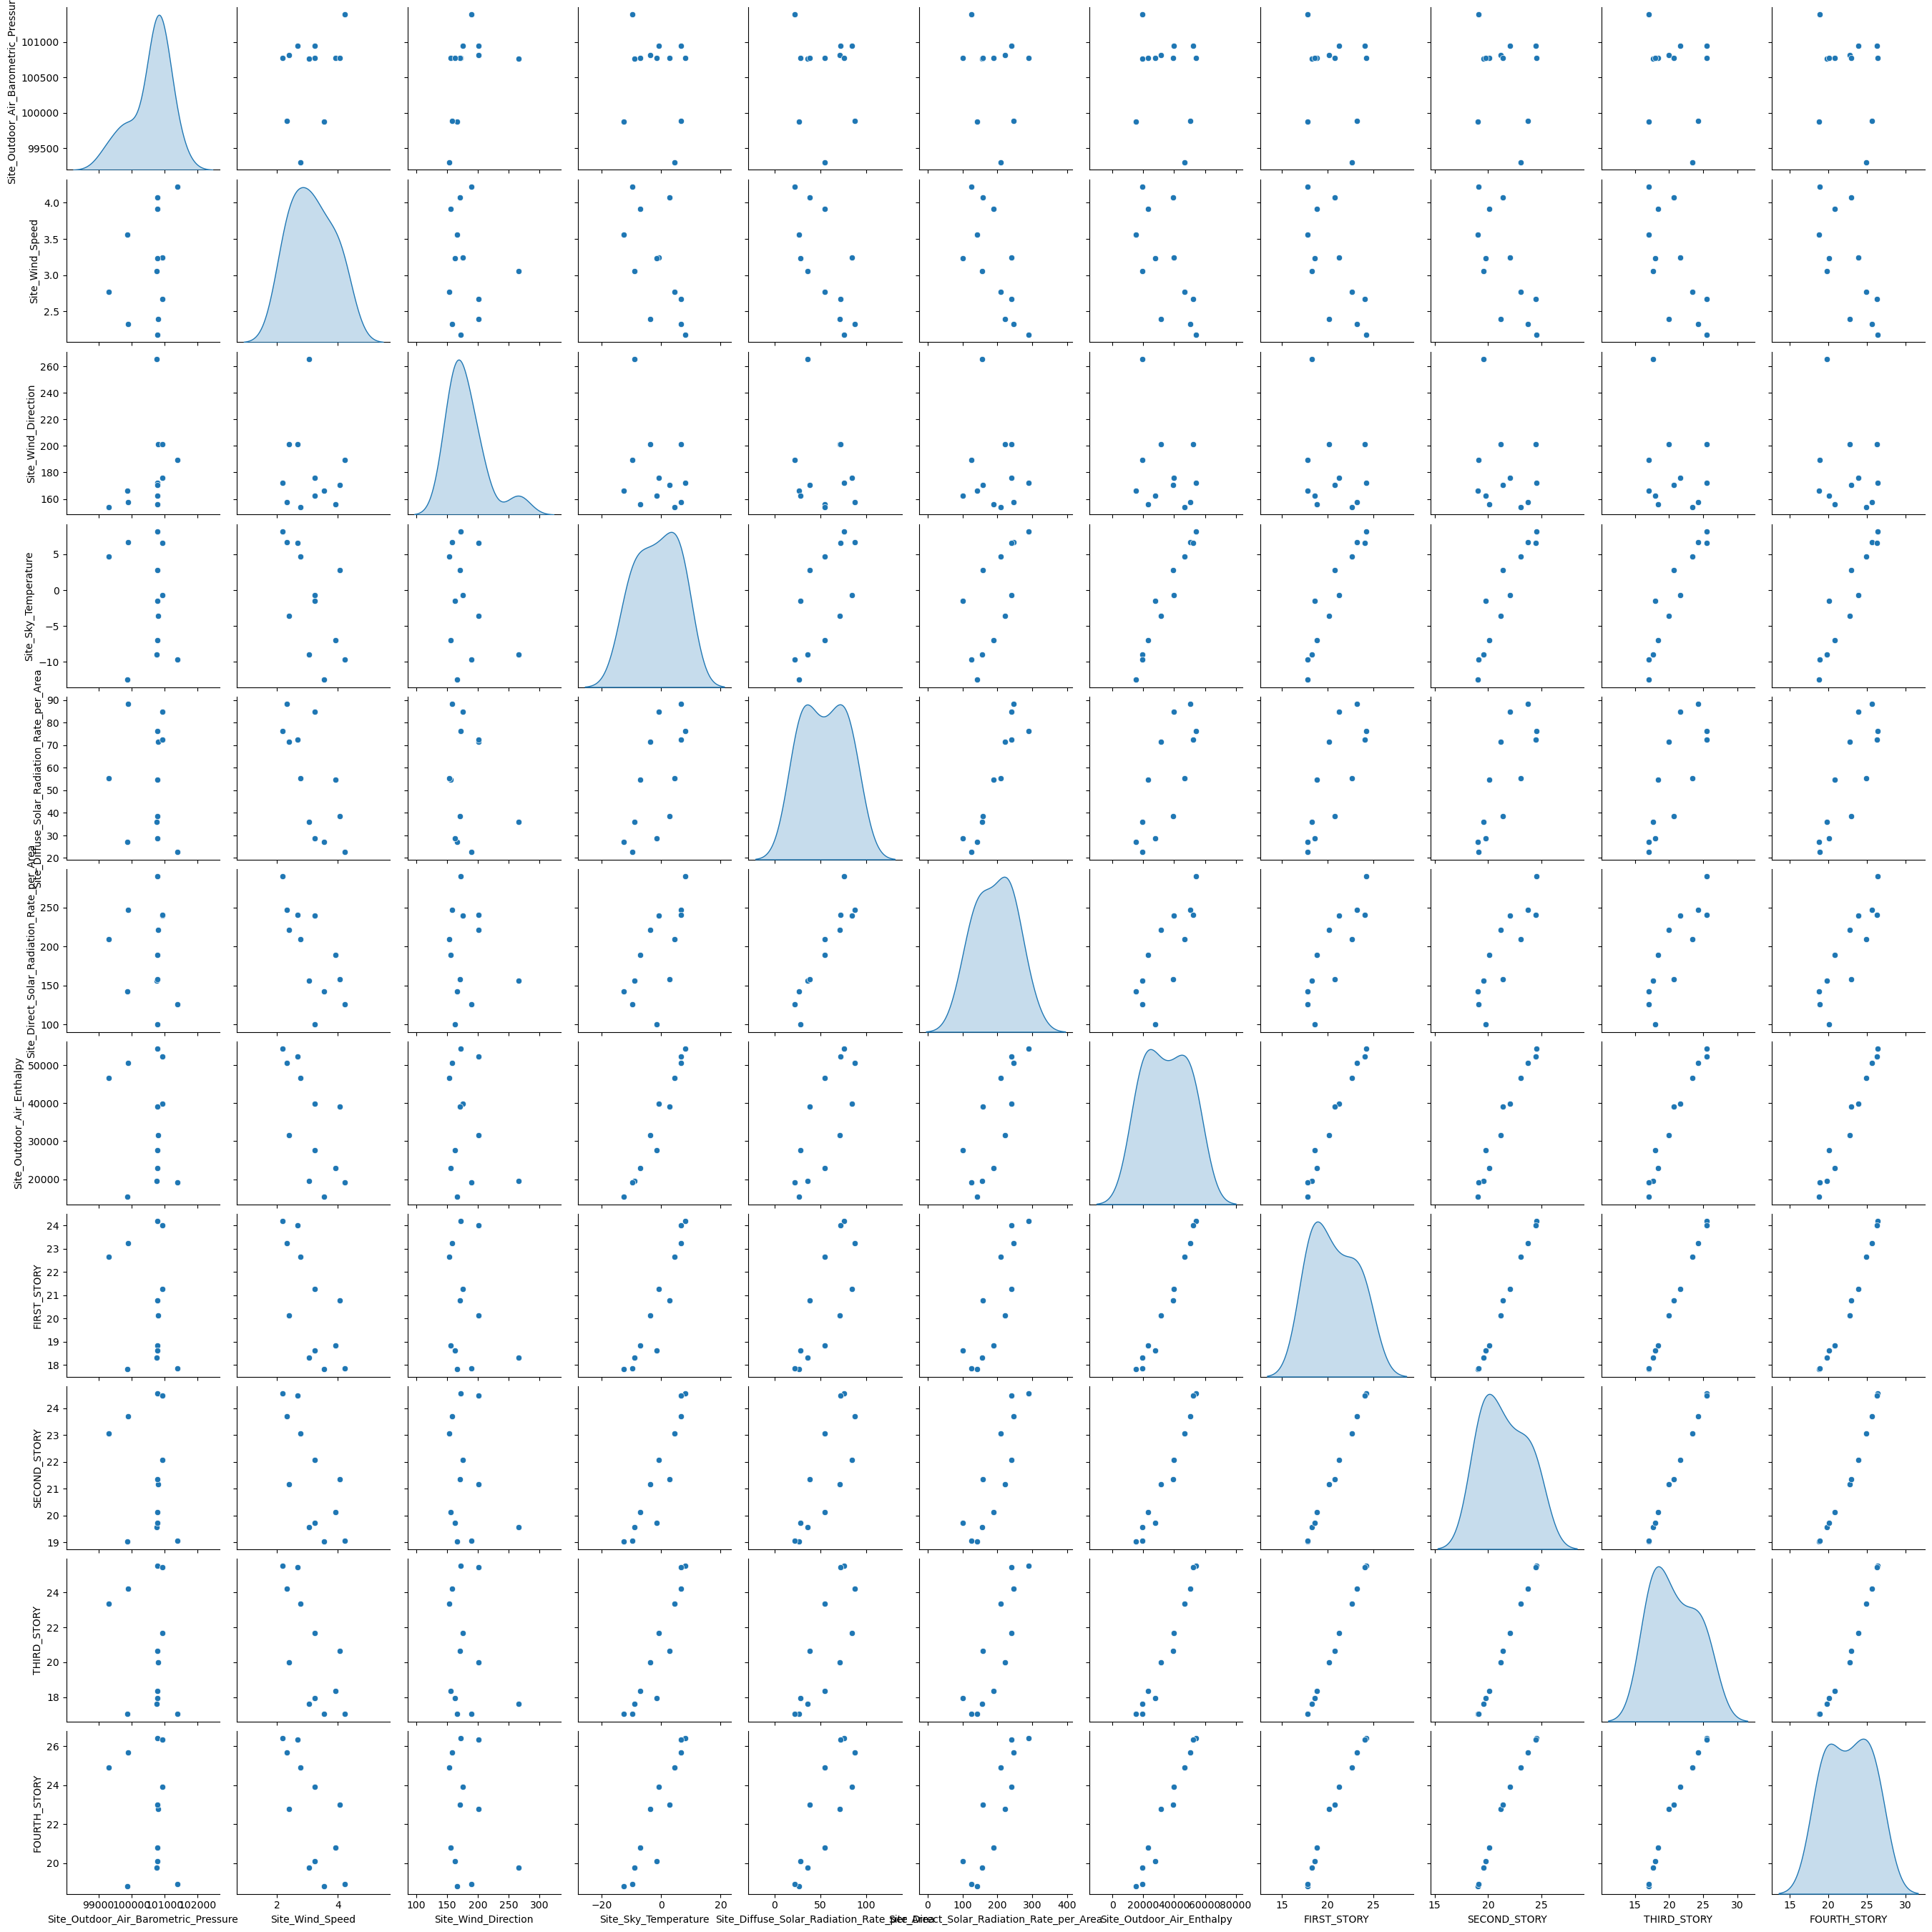

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(New_Column, diag_kind='kde')  # 'kde' for kernel density estimate, 'hist' for histograms

plt.show()

# Exercise:

- Easy

- Medium

- Advanced